In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
os.makedirs('./synthetic_images/', exist_ok=True)


/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best possible Acc: 93.06064757915398


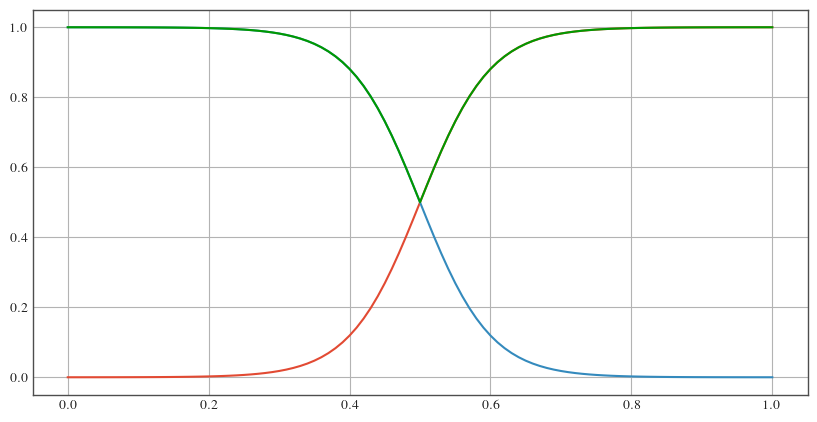

In [143]:
f = lambda x: np.exp(5*x) / np.exp(5)
f = lambda x: x
f = lambda x: 1 / (1 + np.exp(-(x /.05) +10))
# f = lambda x: x

rel_px = np.linspace(0, 1, 101)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
gt_f = lambda x: np.max(np.stack((f(x), 1-f(x))), axis=0)
plt.plot(rel_px, gt_f(rel_px))
print('Best possible Acc:', np.trapz(gt_f(rel_px)))

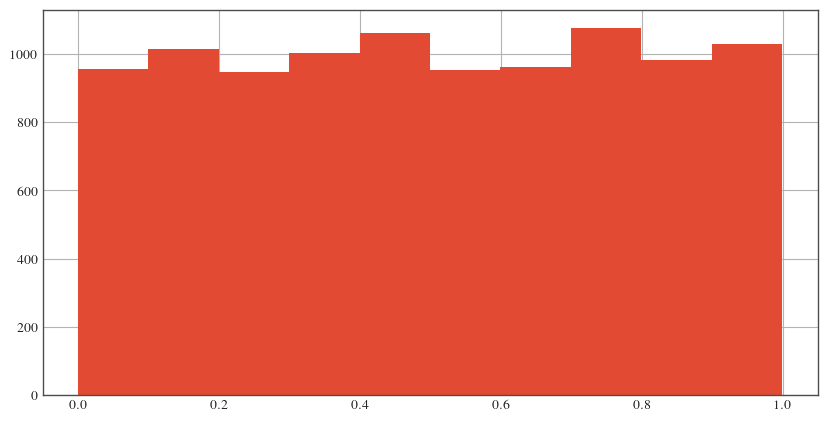

In [144]:
def create_aleatoric_data(n_samples=10_000, img_shape=(3, 32, 32), random_state=None):
    torch.manual_seed(random_state)

    all_imgs = []
    all_targets = []

    # Create a dataset in which the sum of pixels corresponds to the true probability of the label = 1
    n_pixel = np.prod(img_shape)

    for i_sample in range(n_samples):
        img = torch.zeros(n_pixel)

        # Get a random number of pixels to set to one
        n_pixel_to_one = torch.randint(high=n_pixel, size=(1,)).item()
        # Get random positions that should be set to one
        rnd_idx = torch.randperm(n_pixel)[:n_pixel_to_one]
        img[rnd_idx] = 1

        img = img.view(img_shape)
        proba = n_pixel_to_one/n_pixel
        proba = f(proba)
        label = torch.empty(1).bernoulli_(proba).long()

        all_imgs.append(img)
        all_targets.append(label)

    instances = torch.stack(all_imgs).float()
    targets = torch.cat(all_targets).long()
    return instances, targets


from torchvision.transforms import Normalize

instances, targets = create_aleatoric_data(random_state=42)
# mean = instances.mean(dim=(0, 2, 3))
# std = instances.std(dim=(0, 2, 3))
# instances  = Normalize(mean=mean, std=std)(instances)

torch.save({'instances': instances, 'targets': targets}, './synthetic_images/pixel_sum_dataset.pth')
dataset = torch.utils.data.TensorDataset(instances, targets)

plt.hist(instances.mean(dim=(1, 2, 3)))
plt.show()

10000


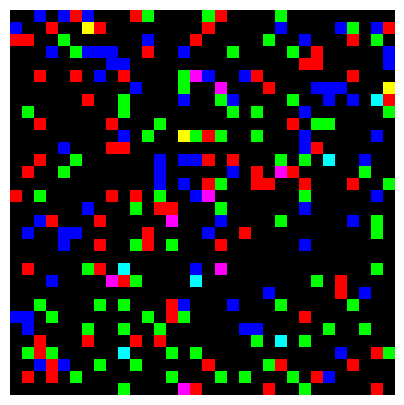

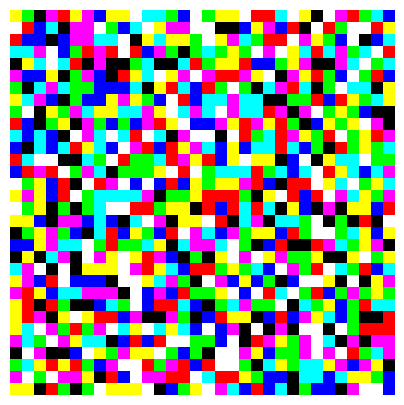

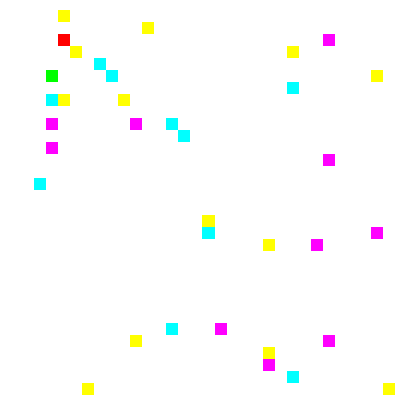

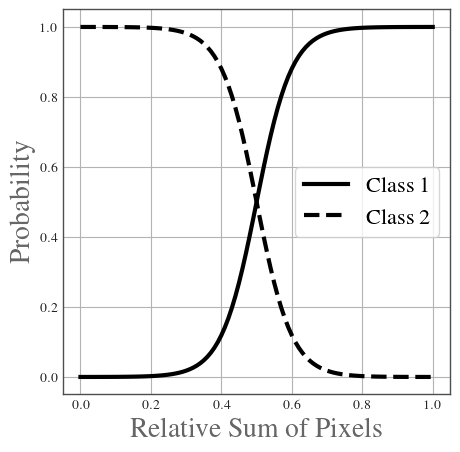

In [145]:
plt.figure(figsize=(5, 5))
print(len(dataset))
gt_probas = instances.mean(dim=(1, 2, 3))

img = instances[gt_probas < .1][-2]

plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/low_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[(gt_probas > .45) & (gt_probas < .55)][0]
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/aleatoric_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[gt_probas > .9][0]
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/high_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
axis = np.linspace(0, 1, 101)
plt.plot(axis, f(axis), linewidth=3, color='k', label='Class 1')
plt.plot(axis, 1-f(axis), linewidth=3, color='k', linestyle='--', label='Class 2')
plt.xlabel('Relative Sum of Pixels', fontdict={'fontsize': 20})
plt.ylabel('Probability', fontdict={'fontsize': 20})
plt.legend(**{'fontsize': 16})
plt.savefig('./synthetic_images/ds_info.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Epoch [0] [ 0/55] eta: 0:00:04 lr: 0.1 loss: 0.9224 (0.9224) acc1: 39.8438 (39.8438) time: 0.0779 data: 0.0013 max mem: 726
Epoch [0] Total time: 0:00:03
{'test_acc1': 66.66667175292969, 'test_prec': 0.8010210936450356, 'test_loss': 0.48714500665664673, 'test_nll': 0.48714500665664673, 'test_tce': 0.13573849201202393, 'test_mce': 0.34589883685112}
Epoch [1] [ 0/55] eta: 0:00:03 lr: 0.09755282581475769 loss: 0.0720 (0.0720) acc1: 98.4375 (98.4375) time: 0.0613 data: 0.0010 max mem: 726
Epoch [1] Total time: 0:00:03
{'test_acc1': 49.366668701171875, 'test_prec': 0.24370677777777777, 'test_loss': 0.5733602046966553, 'test_nll': 0.5733602046966553, 'test_tce': 0.3300153315067291, 'test_mce': 0.3806450366973877}
Epoch [2] [ 0/55] eta: 0:00:03 lr: 0.09045084971874738 loss: 0.1725 (0.1725) acc1: 93.7500 (93.7500) time: 0.0615 data: 0.0012 max mem: 726
Epoch [2] Total time: 0:00:03
{'test_acc1': 49.366668701171875, 'test_prec': 0.24370677777777777, 'test_loss': 0.6256450414657593, 'test_nll': 

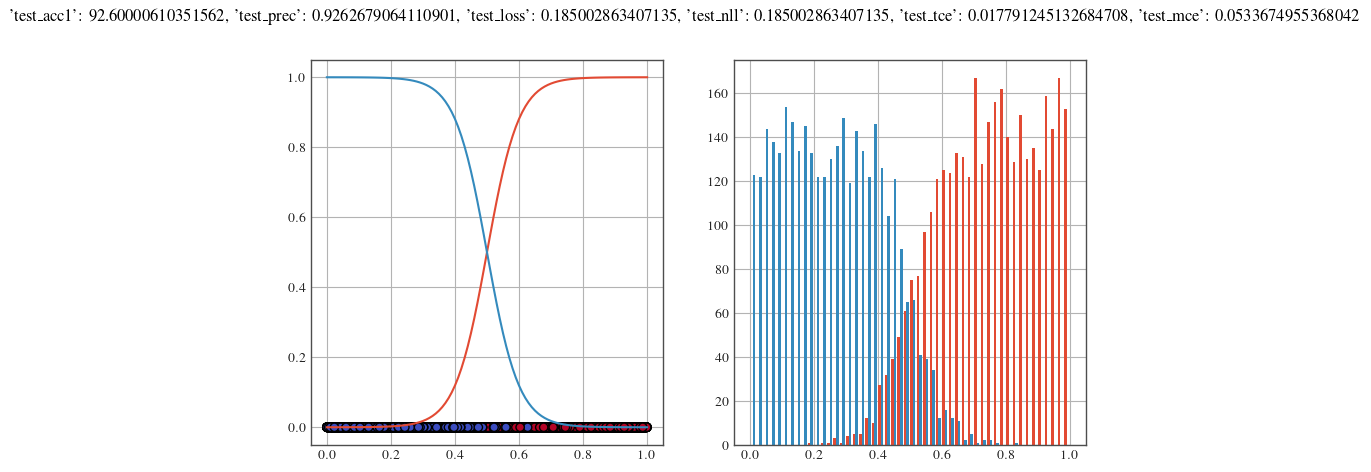

In [146]:
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate
from dal_toolbox.utils import seed_everything

np.random.seed(42)

n_train_samples = int(len(dataset)*.7)
rnd_indices = np.random.permutation(len(dataset))
train_indices = rnd_indices[:n_train_samples]
test_indices = rnd_indices[n_train_samples:]

train_ds = torch.utils.data.Subset(dataset, indices=train_indices[:])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

test_ds = torch.utils.data.Subset(dataset, indices=test_indices)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

n_epochs = 10
model = ResNet18(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
criterion = nn.CrossEntropyLoss()

for i in range(n_epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, epoch=i, device='cuda')
    lr_scheduler.step()
    test_stats = evaluate(model, test_loader, {}, criterion, device='cuda')
    print(test_stats)

# Plot Samples
probs, labels = [], []
for x, y in train_ds:
    probs.append(x.mean())
    labels.append(y)
probs = torch.stack(probs)
labels = torch.stack(labels)

fig = plt.figure(figsize=(10, 5))
rel_px = np.linspace(0, 1, 101)
ax = plt.subplot(121)
fig.suptitle(test_stats)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
plt.scatter(probs, torch.zeros_like(probs), c=labels)
plt.subplot(122, sharex=ax)
plt.hist([probs[labels==1], probs[labels==0]], bins=50)
plt.show()

Acc: 92.60000610351562  TCE: 0.017791245132684708


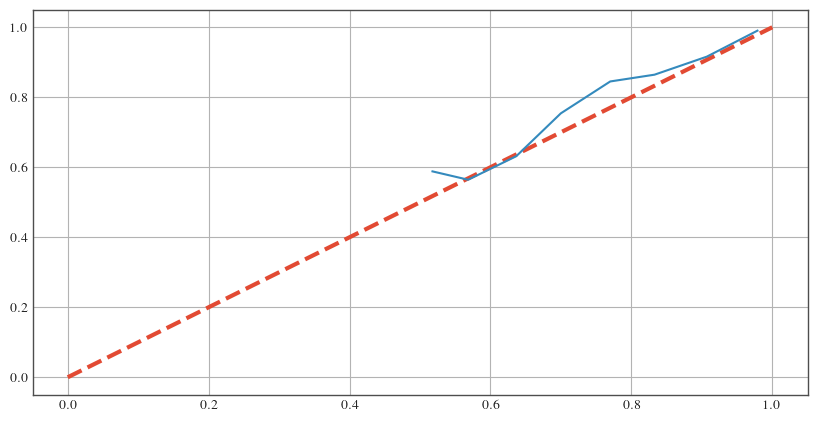

In [147]:
from dal_toolbox.metrics import calibration, generalization

@torch.inference_mode()
def forward_loader(model, dataloader, device='cpu'):
    model.to(device)

    all_logits = []
    all_targets = []
    for images, targets in dataloader:
        logits = model(images.to(device))
        all_logits.append(logits.cpu())
        all_targets.append(targets)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    return {'logits': logits, 'targets': targets}

outputs = forward_loader(model, test_loader, device='cuda')

tce_criterion = calibration.TopLabelCalibrationError()
tce = tce_criterion(outputs['logits'].softmax(-1), outputs['targets'])
acc, = generalization.accuracy(outputs['logits'], outputs['targets'])

plt.plot([0, 1], [0, 1], linestyle='--', linewidth=3)
plt.plot(tce_criterion.results['confs'], tce_criterion.results['accs'])
print('Acc: {}  TCE: {}'.format(acc, tce))

In [148]:
import tqdm
hparams = dict(
    n_reps=10,
    n_samples=20,
    n_epochs=50,
    val_split=.7,
    train_batch_size=128,
    lr=.01,
    momentum=.9,
    weight_decay=0.0
)

tmp = {}

for n_samples in tqdm.tqdm([2, 5, 10, 20, 50, 100, 200, 300, 500]):
    hparams['n_samples'] = n_samples

    results = []
    for seed in range(hparams['n_reps']):
        seed_everything(seed)
        n_train_samples = int(len(dataset)*hparams['val_split'])
        rnd_indices = np.random.permutation(len(dataset))
        train_indices = rnd_indices[:n_train_samples]
        test_indices = rnd_indices[n_train_samples:]

        train_ds = torch.utils.data.Subset(dataset, indices=train_indices[:hparams['n_samples']])
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=hparams['train_batch_size'], shuffle=True)

        test_ds = torch.utils.data.Subset(dataset, indices=test_indices)
        test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

        model = ResNet18(num_classes=2)
        optimizer = torch.optim.SGD(model.parameters(), lr=hparams['lr'], momentum=hparams['momentum'], weight_decay=hparams['weight_decay'])
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hparams['n_epochs'])
        criterion = nn.CrossEntropyLoss()

        for i in range(hparams['n_epochs']):
            train_stats = train_one_epoch(model, train_loader, criterion, optimizer, epoch=i, device='cuda')
            lr_scheduler.step()

        test_stats = evaluate(model, test_loader, {}, criterion, device='cuda')
        print(test_stats)
        results.append(test_stats)

    test_accs = [d['test_acc1'] for d in results]
    tmp[n_samples] = test_accs

    print('Test Accuracy: {:.3f} ± {:.3f}'.format(np.mean(test_accs), np.std(test_accs)))

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.7769 (0.7769) acc1: 50.0000 (50.0000) time: 0.0092 data: 0.0003 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.0602 (0.0602) acc1: 100.0000 (100.0000) time: 0.0108 data: 0.0002 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0477 (0.0477) acc1: 100.0000 (100.0000) time: 0.0094 data: 0.0001 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0210 (0.0210) acc1: 100.0000 (100.0000) time: 0.0115 data: 0.0002 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0093 (0.0093) acc1: 100.0000 (100.0000) time: 0.0112 data: 0.0002 max mem: 726
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.009755282581475767 loss: 0.0042 (0.0042) acc1: 100.0000 (100.0000) time: 0.0090 data: 0.0001 max mem: 726
Epoch [5] Total time: 

 11%|█         | 1/9 [00:10<01:24, 10.61s/it]

{'test_acc1': 49.333335876464844, 'test_prec': 0.24337777777777778, 'test_loss': 1.3012031316757202, 'test_nll': 1.3012031316757202, 'test_tce': 0.43545714020729065, 'test_mce': 0.5222599506378174}
Test Accuracy: 57.127 ± 12.087
Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8708 (0.8708) acc1: 20.0000 (20.0000) time: 0.0093 data: 0.0003 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.0451 (0.0451) acc1: 100.0000 (100.0000) time: 0.0098 data: 0.0001 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0895 (0.0895) acc1: 100.0000 (100.0000) time: 0.0115 data: 0.0002 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0123 (0.0123) acc1: 100.0000 (100.0000) time: 0.0112 data: 0.0002 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0052 (0.0052) acc1: 100.0000 (100.0000) tim

 22%|██▏       | 2/9 [00:21<01:15, 10.78s/it]

{'test_acc1': 50.66666793823242, 'test_prec': 0.25671111111111117, 'test_loss': 4.073251724243164, 'test_nll': 4.073251724243164, 'test_tce': 0.493147611618042, 'test_mce': 0.493147611618042}
Test Accuracy: 68.407 ± 10.626
Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8415 (0.8415) acc1: 20.0000 (20.0000) time: 0.0117 data: 0.0003 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.0400 (0.0400) acc1: 100.0000 (100.0000) time: 0.0119 data: 0.0002 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0416 (0.0416) acc1: 100.0000 (100.0000) time: 0.0119 data: 0.0002 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0286 (0.0286) acc1: 100.0000 (100.0000) time: 0.0118 data: 0.0001 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0097 (0.0097) acc1: 100.0000 (100.0000) time: 0.0

 33%|███▎      | 3/9 [00:32<01:06, 11.10s/it]

{'test_acc1': 79.93333435058594, 'test_prec': 0.8569044035674471, 'test_loss': 0.6255050301551819, 'test_nll': 0.6255050301551819, 'test_tce': 0.14447814226150513, 'test_mce': 0.2809433341026306}
Test Accuracy: 72.627 ± 10.832
Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8780 (0.8780) acc1: 15.0000 (15.0000) time: 0.0137 data: 0.0004 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.1205 (0.1205) acc1: 100.0000 (100.0000) time: 0.0151 data: 0.0003 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0736 (0.0736) acc1: 100.0000 (100.0000) time: 0.0153 data: 0.0003 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0199 (0.0199) acc1: 100.0000 (100.0000) time: 0.0153 data: 0.0003 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0055 (0.0055) acc1: 100.0000 (100.0000) time:

 44%|████▍     | 4/9 [00:45<00:58, 11.78s/it]

{'test_acc1': 86.36666870117188, 'test_prec': 0.8902018365637117, 'test_loss': 0.3339892029762268, 'test_nll': 0.3339892029762268, 'test_tce': 0.061944860965013504, 'test_mce': 0.20090948045253754}
Test Accuracy: 76.397 ± 11.510
Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8753 (0.8753) acc1: 32.0000 (32.0000) time: 0.0245 data: 0.0006 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.3964 (0.3964) acc1: 68.0000 (68.0000) time: 0.0249 data: 0.0004 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.1886 (0.1886) acc1: 94.0000 (94.0000) time: 0.0251 data: 0.0003 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0350 (0.0350) acc1: 100.0000 (100.0000) time: 0.0272 data: 0.0003 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0147 (0.0147) acc1: 100.0000 (100.0000) time: 0

 56%|█████▌    | 5/9 [01:03<00:55, 13.91s/it]

{'test_acc1': 89.03334045410156, 'test_prec': 0.9060321741820507, 'test_loss': 0.3531217575073242, 'test_nll': 0.3531217575073242, 'test_tce': 0.06818968057632446, 'test_mce': 0.15675866603851318}
Test Accuracy: 85.487 ± 4.801
Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8471 (0.8471) acc1: 39.0000 (39.0000) time: 0.0436 data: 0.0008 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.4979 (0.4979) acc1: 59.0000 (59.0000) time: 0.0456 data: 0.0006 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.2597 (0.2597) acc1: 98.0000 (98.0000) time: 0.0494 data: 0.0007 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0856 (0.0856) acc1: 100.0000 (100.0000) time: 0.0457 data: 0.0006 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0539 (0.0539) acc1: 99.0000 (99.0000) time: 0.048

 67%|██████▋   | 6/9 [01:32<00:57, 19.13s/it]

{'test_acc1': 88.86666870117188, 'test_prec': 0.9041947975872726, 'test_loss': 0.38286125659942627, 'test_nll': 0.38286125659942627, 'test_tce': 0.07738273590803146, 'test_mce': 0.15185508131980896}
Test Accuracy: 88.777 ± 3.655
Epoch [0] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.8194 (0.8194) acc1: 44.5312 (44.5312) time: 0.0588 data: 0.0011 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.3499 (0.3499) acc1: 91.4062 (91.4062) time: 0.0647 data: 0.0008 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.1109 (0.1109) acc1: 96.8750 (96.8750) time: 0.0625 data: 0.0008 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0783 (0.0783) acc1: 97.6562 (97.6562) time: 0.0660 data: 0.0008 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0549 (0.0549) acc1: 99.2188 (99.2188) time: 0.065

 78%|███████▊  | 7/9 [02:28<01:02, 31.14s/it]

{'test_acc1': 91.43333435058594, 'test_prec': 0.9171342845198757, 'test_loss': 0.27678120136260986, 'test_nll': 0.27678120136260986, 'test_tce': 0.062334541231393814, 'test_mce': 0.09062249213457108}
Test Accuracy: 91.770 ± 0.831
Epoch [0] [0/3] eta: 0:00:00 lr: 0.01 loss: 0.8377 (0.8377) acc1: 38.2812 (38.2812) time: 0.0581 data: 0.0010 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/3] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.2471 (0.2471) acc1: 92.1875 (92.1875) time: 0.0654 data: 0.0008 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/3] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0697 (0.0697) acc1: 98.4375 (98.4375) time: 0.0641 data: 0.0007 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/3] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0567 (0.0567) acc1: 96.8750 (96.8750) time: 0.0632 data: 0.0008 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/3] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0066 (0.0066) acc1: 100.0000 (100.0000) time: 0.

 89%|████████▉ | 8/9 [03:49<00:46, 46.93s/it]

{'test_acc1': 91.66667175292969, 'test_prec': 0.9189972790936259, 'test_loss': 0.3183537721633911, 'test_nll': 0.3183537721633911, 'test_tce': 0.0744679868221283, 'test_mce': 0.09337318688631058}
Test Accuracy: 91.347 ± 1.576
Epoch [0] [0/4] eta: 0:00:00 lr: 0.01 loss: 0.8135 (0.8135) acc1: 43.7500 (43.7500) time: 0.0580 data: 0.0010 max mem: 726
Epoch [0] Total time: 0:00:00
Epoch [1] [0/4] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.1961 (0.1961) acc1: 92.9688 (92.9688) time: 0.0618 data: 0.0008 max mem: 726
Epoch [1] Total time: 0:00:00
Epoch [2] [0/4] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.2292 (0.2292) acc1: 92.9688 (92.9688) time: 0.0608 data: 0.0008 max mem: 726
Epoch [2] Total time: 0:00:00
Epoch [3] [0/4] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0458 (0.0458) acc1: 99.2188 (99.2188) time: 0.0611 data: 0.0008 max mem: 726
Epoch [3] Total time: 0:00:00
Epoch [4] [0/4] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0133 (0.0133) acc1: 100.0000 (100.0000) time: 0.0609

100%|██████████| 9/9 [05:55<00:00, 39.54s/it]

{'test_acc1': 92.00000762939453, 'test_prec': 0.9213157055876795, 'test_loss': 0.3430417478084564, 'test_nll': 0.3430417478084564, 'test_tce': 0.08335825055837631, 'test_mce': 0.09120985865592957}
Test Accuracy: 92.170 ± 0.473


In [154]:
for n_samples, test_accs in tmp.items():
    print('N = {} Test Accuracy: {:.3f} ± {:.3f}'.format(n_samples, np.mean(test_accs), np.std(test_accs) /np.sqrt(1)))

N = 2 Test Accuracy: 57.127 ± 12.087
N = 5 Test Accuracy: 68.407 ± 10.626
N = 10 Test Accuracy: 72.627 ± 10.832
N = 20 Test Accuracy: 76.397 ± 11.510
N = 50 Test Accuracy: 85.487 ± 4.801
N = 100 Test Accuracy: 88.777 ± 3.655
N = 200 Test Accuracy: 91.770 ± 0.831
N = 300 Test Accuracy: 91.347 ± 1.576
N = 500 Test Accuracy: 92.170 ± 0.473
